<a href="https://colab.research.google.com/github/GusSampaio/Classificacao_Multirrotulo_no_Dominio_Juridico/blob/main/Minera%C3%A7%C3%A3o_de_Textos_para_Dom%C3%ADnio_Jur%C3%ADdico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Extensionista - Classificação Multirrótulo no Domínio Jurídico

O objetivo deste projeto é desenvolver uma solução de classificação multirrótulo aplicada ao domínio jurídico. Em particular, trabalharemos com processos que podem estar associados a múltiplos assuntos, o que exige uma abordagem específica para lidar com esse tipo de dados.

Guilherme Panza - 
Gustavo Sampaio - 12623992


In [1]:
# Importando bibliotecas necessarias
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from torch.utils.data import DataLoader
import gc
from scipy import sparse

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModel, AutoModelForPreTraining
import concurrent.futures

from skmultilearn.adapt import MLkNN
from sklearn.metrics import f1_score, classification_report

# Manipulação e visualização de dados
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Divisão de dados e pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Treinamento de redes neurais
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Avaliação dos modelos
from sklearn.metrics import classification_report, roc_curve, auc, hamming_loss, f1_score, precision_score, recall_score, confusion_matrix

2025-03-22 15:52:41.156966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742658761.172898   98372 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742658761.177625   98372 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742658761.194389   98372 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742658761.194401   98372 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742658761.194403   98372 computation_placer.cc:177] computation placer alr

# Leitura da Base de Dados

In [44]:
# Baixando bases de dados de treino
!gdown 1E_aecYDw69UgYbgzQCjtP9rWonwpyFuJ -O data/
!gdown 1--unYhhi0HoMFT4kNyf91WwckjlTedYo -O data/

Downloading...
From (original): https://drive.google.com/uc?id=1E_aecYDw69UgYbgzQCjtP9rWonwpyFuJ
From (redirected): https://drive.google.com/uc?id=1E_aecYDw69UgYbgzQCjtP9rWonwpyFuJ&confirm=t&uuid=1c78cd41-dade-4da9-a121-2eb4b0e3f470
To: /home/gustavo/Classificacao_Multirrotulo_no_Dominio_Juridico/data/X_train.pkl
100%|█████████████████████████████████████████| 878M/878M [00:08<00:00, 105MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1--unYhhi0HoMFT4kNyf91WwckjlTedYo
From (redirected): https://drive.google.com/uc?id=1--unYhhi0HoMFT4kNyf91WwckjlTedYo&confirm=t&uuid=5cef4e63-d2d6-4edc-98b4-f8d14d647958
To: /home/gustavo/Classificacao_Multirrotulo_no_Dominio_Juridico/data/Y_train.pkl
100%|████████████████████████████████████████| 138M/138M [00:01<00:00, 96.4MB/s]


In [45]:
X_train = pd.read_pickle("data/X_train.pkl")
y_train = pd.read_pickle("data/Y_train.pkl")

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [46]:
# Baixando embeddings gerados pelos modelos
!gdown 1-zqYLsxoeTbNKQVCmNHiBGkY47VjnUp_ -O data/
!gdown 1eHDUOcD_6eoFzLBxMpl1nKqb5ZdkZpe3 -O data/
!gdown 1_EfPkFA5d3JUhKZo2xhMhi0YNdBsEtyO -O data/
!gdown 1_JC42R_dCtRaq29_QWVnBl3AHYJ1Ud8a -O data/
!gdown 17y51W5Wi10qb0NhHd8qsuo_7DpjOlK2Y -O data/
!gdown 1thqrRFZcUAvRlckGv9XLuV34x7EyUhP1 -O data/

Downloading...
From (original): https://drive.google.com/uc?id=1-zqYLsxoeTbNKQVCmNHiBGkY47VjnUp_
From (redirected): https://drive.google.com/uc?id=1-zqYLsxoeTbNKQVCmNHiBGkY47VjnUp_&confirm=t&uuid=f9e6d9ea-07cc-452d-b149-5c365bea55ac
To: /home/gustavo/Classificacao_Multirrotulo_no_Dominio_Juridico/data/X_train_multilingual_embeddings.npz
100%|███████████████████████████████████████| 35.5M/35.5M [00:00<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eHDUOcD_6eoFzLBxMpl1nKqb5ZdkZpe3
To: /home/gustavo/Classificacao_Multirrotulo_no_Dominio_Juridico/data/X_val_multilingual_embeddings.npz
100%|██████████████████████████████████████| 7.11M/7.11M [00:00<00:00, 74.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_EfPkFA5d3JUhKZo2xhMhi0YNdBsEtyO
To: /home/gustavo/Classificacao_Multirrotulo_no_Dominio_Juridico/data/X_train_multilingual2_embeddings.npy
100%|███████████████████████████████████████| 38.4M/38.4M [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.

In [47]:
X_train_multilingual_embeddings = np.load("data/X_train_multilingual_embeddings.npz")["arr_0"]
X_val_multilingual_embeddings = np.load("data/X_val_multilingual_embeddings.npz")["arr_0"]
X_train_multilingual2_embeddings = np.load("data/X_train_multilingual2_embeddings.npy")
X_val_multilingual2_embeddings = np.load("data/X_val_multilingual2_embeddings.npy")
X_test_multilingual_embeddings = np.load("data/X_test_multilingual_embeddings.npy")
X_test_multilingual2_embeddings = np.load("data/X_test_multilingual2_embeddings.npy")

In [48]:
# Baixando dados de teste
!gdown 1QfrgY6HDhRk2XN_YESE36xzI7lqVawj7 -O data/
!gdown 1-1t9vToIC9JnzS03mzwLLUS0xnS3egWG -O data/

Downloading...
From (original): https://drive.google.com/uc?id=1QfrgY6HDhRk2XN_YESE36xzI7lqVawj7
From (redirected): https://drive.google.com/uc?id=1QfrgY6HDhRk2XN_YESE36xzI7lqVawj7&confirm=t&uuid=661b8c79-761c-44b8-b1aa-992782cf5a28
To: /home/gustavo/Classificacao_Multirrotulo_no_Dominio_Juridico/data/X_test.pkl
100%|████████████████████████████████████████| 253M/253M [00:03<00:00, 77.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1t9vToIC9JnzS03mzwLLUS0xnS3egWG
To: /home/gustavo/Classificacao_Multirrotulo_no_Dominio_Juridico/data/Y_test.pkl
100%|███████████████████████████████████████| 34.4M/34.4M [00:00<00:00, 106MB/s]


In [49]:
X_test = pd.read_pickle("data/X_test.pkl")
y_test = pd.read_pickle("data/Y_test.pkl")

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [9]:
# Se os tamanhos dos samples e/ou o estado aleatório forem alterados, a geração
# de novos embeddings deve acontecer pois a reprodutibilidade do experimento se perde
np.random.seed(0)  # Define a semente para reprodutibilidade
train_positions = np.random.choice(len(X_train), size=30000, replace=False)
test_positions = np.random.choice(len(X_test), size=5000, replace=False)

X_train_sample = X_train.loc[train_positions]
y_train_sample = y_train.loc[train_positions]
X_test_sample = X_test.loc[test_positions]
y_test_sample = y_test.loc[test_positions]

## Análise Exploratória Descritiva

In [10]:
X_train_sample.head()

,texto
32150,"DECISÃO: Vistos, etc. Trata-se de recurso extr..."
51477,DECISÃO: O Plenário do Supremo Tribunal Federa...
119933,DECISÃO RECURSO EXTRAORDINÁRIO COM AGRAVO. ADM...
181198,RECURSO EXTRAORDINÁRIO COM AGRAVO. ADMINISTRAT...
118180,Decisão: 1. Trata-se de agravo de decisão que ...


In [11]:
x_train_size = X_train_sample.shape[0]
print("Tamanho do conjunto de treino:",x_train_size,'textos diferentes')

Tamanho do conjunto de treino: 30000 textos diferentes


In [12]:
y_train_sample.head()

,DIREITO DO TRABALHO,SISTEMA REMUNERATORIO E BENE,RMI RENDA MENSAL INICIAL REAJUSTES E REVISOES ESPECIFICAS,ATOS PROCESSUAIS,RESPONSABILIDADE CIVIL,COFINSDIREITO TRIBUTARIO,DIREITO PROCESSUAL PENAL,ATOS ADMINISTRATIVOS,CONTRIBUICOES PREVIDENCIARIAS,LIMITACOES AO PODER DE TRIBUTAR,...,CRIMES DE LAVAGEM OU OCULTACAO DE BE,DIREITO ADMINISTRATIVO E OUTRAS MATERIAS DE DIREITO PUBLICO,APOSENTADORIA,RESCISAO DO CONTRATO DE TRABALHO,CRIMES PREVISTOS NA LEGISLACAO EXTRAVAGANTE,BENEFICIOS EM ESPECIE,PARTES E PROCURADORES,MAGISTRATURA,PRISAO PREVENTIVA,EXCESSO DE PRAZO PARA INSTRUCAO / JULGAMENTO
32150,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
51477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118180,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [13]:
print("Exemplo de texto jurídico:")
display(X_train_sample.loc[32150].texto)

print("\nClasses atribuídas a ele:")
for index, row in pd.DataFrame(y_train.loc[0]).iterrows():
  if row[0] != 0:
    print(row.name)

Exemplo de texto jurídico:


'DECISÃO: Vistos, etc. Trata-se de recurso extraordinário, manejado com suporte na alínea “a” do inciso III do art. 102 da Constituição Republicana, contra acórdão do Tribunal de Justiça do Estado do Rio Grande do Sul. Acórdão assim ementado (fls. 390): “CONCURSO PÚBLICO. PROCESSUAL CIVIL. AÇÃO CIVIL PÚBLICA. PRELIMINAR DE ILEGITIMIDADE PASSIVA AFASTADA. LIMITAÇÃO ETÁRIA CONSTANTE DO EDITAL. PRETENSÃO A ANULAÇÃO DO CONCURSO. CASO CONCRETO EM QUE A LEI QUE EMBASA O EDITAL PREVÊ A LIMITAÇÃO IMPOSTA. INTERESSE PÚBLICO QUE SE MOSTRA PREVALENTE. APELAÇÃO PROVIDA. UNÂNIME.” 2. Pois bem, a parte recorrente aponta violação ao inciso XXX do art. 7°, ao § 3° do art. 39 e ao § 9° do art. 201, todos da Magna Carta de 1988. 3. A seu turno, a Procuradoria-Geral da República, em parecer da lavra da Subprocuradora-Geral Sandra Cureau, opina pelo provimento do apelo extremo. 4. Tenho que a insurgência merece acolhida. Isso porque o aresto impugnado destoa da jurisprudência desta nossa Corte, firme no s


Classes atribuídas a ele:
REGIME ESTATU
SERVIDOR PUBLICO CIVIL
DIREITO ADMINISTRATIVO E OUTRAS MATERIAS DE DIREITO PUBLICO


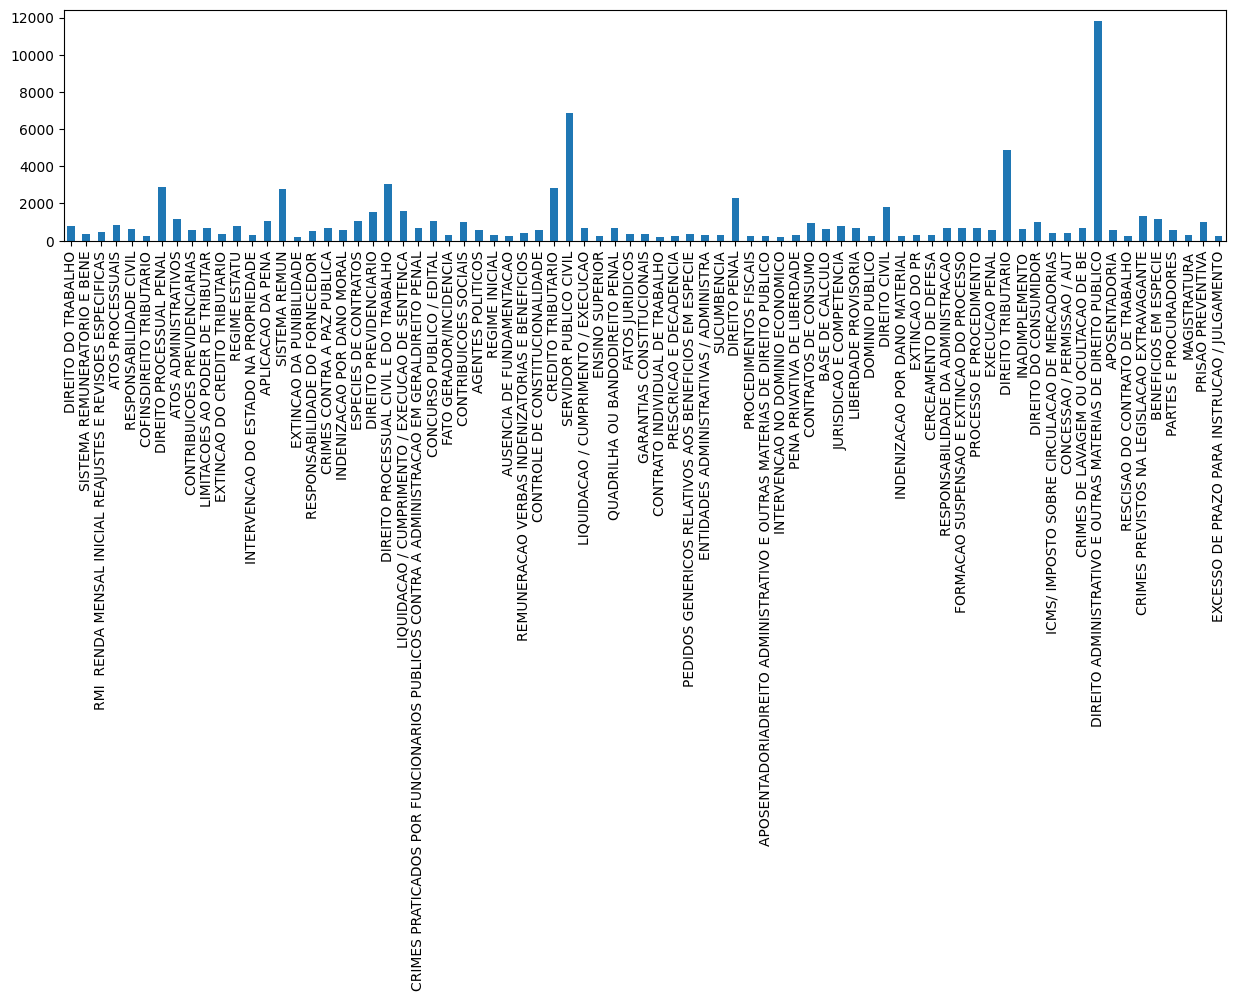

In [14]:
# Distribuição das classes.
y_train_sample.sum().plot.bar(figsize=(15, 3))
plt.show()

# Separando um conjunto de validação

In [15]:
mskf = MultilabelStratifiedKFold(n_splits=6, shuffle=True, random_state=0)

for train_index, test_index in mskf.split(X_train_sample, y_train_sample):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train_sample, X_val_sample = X_train_sample.iloc[train_index], X_train_sample.iloc[test_index]
   y_train_sample, y_val_sample = y_train_sample.iloc[train_index], y_train_sample.iloc[test_index]
   break

TRAIN: [    0     2     3 ... 29995 29996 29999] TEST: [    1     5     7 ... 29989 29997 29998]


In [16]:
len(X_train_sample), len(X_val_sample)

(25002, 4998)

In [17]:
len(y_train_sample), len(y_val_sample)

(25002, 4998)

In [18]:
len(X_test_sample), len(y_test_sample)

(5000, 5000)

# Pré-processamento



In [19]:
# Criando representações vetoriais (em formato de matriz TF-IDF) a partir dos textos
nltk.download("stopwords")

vectorizer = TfidfVectorizer(
    stop_words=stopwords.words("portuguese"),
    min_df=5
)

X_train_tf = vectorizer.fit_transform(X_train_sample.texto.to_list())
X_val_tf = vectorizer.transform(X_val_sample.texto.to_list())

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gustavo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Gerando embedings de modelos linguísticos
Rodar SOMENTE em casos onde os embeddings não puderem ser baixados anteriormente

In [19]:
# #Instanciando modelo gerador de embeddings multilinguais
# multilingual_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# X_train_multilingual_embeddings = multilingual_model.encode(
#     X_train_sample.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# X_val_multilingual_embeddings = multilingual_model.encode(
#     X_val_sample.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# np.savez_compressed("X_train_multilingual_embeddings.npz", X_train_multilingual_embeddings)
# np.savez_compressed("X_val_multilingual_embeddings.npz", X_val_multilingual_embeddings)

In [20]:
# # Instanciando modelo gerador de embeddings multilinguais
# multilingual2_model = SentenceTransformer('all-MiniLM-L6-v2')

# X_train_multilingual2_embeddings = multilingual2_model.encode(
#     X_train_sample.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# X_val_multilingual2_embeddings = multilingual2_model.encode(
#     X_val_sample.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# np.save("X_train_multilingual2_embeddings.npy", X_train_multilingual2_embeddings)
# np.save("X_val_multilingual2_embeddings.npy", X_val_multilingual2_embeddings)

In [21]:
# X_test_multilingual_embeddings = multilingual_model.encode(
#     X_test_sample.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# X_test_multilingual2_embeddings = multilingual2_model.encode(
#     X_test_sample.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# np.save("X_test_multilingual_embeddings.npy", X_test_multilingual_embeddings)
# np.save("X_test_multilingual2_embeddings.npy", X_test_multilingual2_embeddings)

# Treinamento e avaliação dos modelos

In [20]:
# Transformando vetores de classes para formato apropriado a esparso
s_Ytrain = sparse.csr_matrix(np.array(y_train_sample))
s_Yval = sparse.csr_matrix(np.array(y_val_sample))
s_Ytest = sparse.csr_matrix(np.array(y_test_sample))

### Treinando knn para embeddings multilinguais 1

In [21]:
s_Xtrain = sparse.csr_matrix(X_train_multilingual_embeddings)
s_Xval = sparse.csr_matrix(X_val_multilingual_embeddings)

# Faixa de valores de k para testar
k_values = [10, 50, 100]

best_k = None
best_f1 = 0

classifiers = {}

for k in k_values:
    # Instancia o modelo com o valor atual de k
    classifier = MLkNN(k=k)

    # Treina o modelo nos dados de treinamento
    classifier.fit(s_Xtrain, s_Ytrain)
    classifiers[k] = classifier

    # Faz predições no conjunto de validação
    predictions = classifier.predict(s_Xval)

    # Calcula o F1-Score no conjunto de validação
    f1 = f1_score(s_Yval, predictions, average="weighted")

    print(f"F1-Score para k={k}: {f1}")

    # Atualiza o melhor k com base no F1-Score
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"Melhor k: {best_k} com F1-Score: {best_f1}")

# Considera o modelo final com o melhor k encontrado
final_classifier_1 = classifiers[best_k]

F1-Score para k=10: 0.328988678544206
F1-Score para k=50: 0.2843175568849789
F1-Score para k=100: 0.2609514823980771
Melhor k: 10 com F1-Score: 0.328988678544206


In [22]:
s_Xtest = sparse.csr_matrix(X_test_multilingual_embeddings)

# Avalia o modelo final no conjunto de teste
test_predictions = final_classifier_1.predict(s_Xtest)

print("F1-Score no Teste (weighted):", f1_score(s_Ytest, test_predictions, average="weighted"))
print("Relatório de Classificação no Teste:\n", classification_report(s_Ytest, test_predictions))

F1-Score no Teste (weighted): 0.34378188006521
Relatório de Classificação no Teste:
               precision    recall  f1-score   support

           0       0.82      0.11      0.19       127
           1       0.67      0.09      0.16        68
           2       0.57      0.05      0.09        79
           3       0.00      0.00      0.00       150
           4       0.00      0.00      0.00       103
           5       0.75      0.07      0.12        46
           6       0.72      0.67      0.69       482
           7       0.38      0.02      0.05       202
           8       0.50      0.10      0.17       101
           9       0.79      0.10      0.18       105
          10       0.00      0.00      0.00        55
          11       0.36      0.03      0.06       133
          12       0.88      0.11      0.20        62
          13       0.55      0.15      0.24       175
          14       0.56      0.16      0.25       459
          15       0.00      0.00      0.00       

/home/gustavo/Classificacao_Multirrotulo_no_Dominio_Juridico/juridico/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gustavo/Classificacao_Multirrotulo_no_Dominio_Juridico/juridico/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Avaliando knn para embeddings multilinguais 2

In [23]:
s_Xtrain = sparse.csr_matrix(X_train_multilingual2_embeddings)
s_Xval = sparse.csr_matrix(X_val_multilingual2_embeddings)

# Faixa de valores de k para testar
k_values = [10, 50, 100]

best_k = None
best_f1 = 0

classifiers = {}

for k in k_values:
    # Instancia o modelo com o valor atual de k
    classifier = MLkNN(k=k)

    # Treina o modelo nos dados de treinamento
    classifier.fit(s_Xtrain, s_Ytrain)
    classifiers[k] = classifier

    # Faz predições no conjunto de validação
    predictions = classifier.predict(s_Xval)

    # Calcula o F1-Score no conjunto de validação
    f1 = f1_score(s_Yval, predictions, average="weighted")

    print(f"F1-Score para k={k}: {f1}")

    # Atualiza o melhor k com base no F1-Score
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"Melhor k: {best_k} com F1-Score: {best_f1}")

# Considera o modelo final com o melhor k encontrado
final_classifier_2 = classifiers[best_k]

F1-Score para k=10: 0.3761308829540569
F1-Score para k=50: 0.3281198750998487
F1-Score para k=100: 0.3159213214715131
Melhor k: 10 com F1-Score: 0.3761308829540569


In [24]:
s_Xtest = sparse.csr_matrix(X_test_multilingual2_embeddings)

# Avalia o modelo final no conjunto de teste
test_predictions = final_classifier_2.predict(s_Xtest)

print("F1-Score no Teste (weighted):", f1_score(s_Ytest, test_predictions, average="weighted"))
print("Relatório de Classificação no Teste:\n", classification_report(s_Ytest, test_predictions))

F1-Score no Teste (weighted): 0.3857051725417762
Relatório de Classificação no Teste:
               precision    recall  f1-score   support

           0       0.52      0.20      0.29       127
           1       0.50      0.10      0.17        68
           2       0.39      0.15      0.22        79
           3       0.00      0.00      0.00       150
           4       0.00      0.00      0.00       103
           5       0.50      0.11      0.18        46
           6       0.76      0.70      0.73       482
           7       0.45      0.02      0.05       202
           8       0.55      0.11      0.18       101
           9       0.43      0.17      0.24       105
          10       0.00      0.00      0.00        55
          11       0.83      0.04      0.07       133
          12       0.41      0.11      0.18        62
          13       0.60      0.30      0.40       175
          14       0.55      0.15      0.23       459
          15       0.50      0.03      0.06     

### Avaliando knn matriz tf-idf

In [25]:
s_Xtrain = sparse.csr_matrix(X_train_tf)
s_Xval = sparse.csr_matrix(X_val_tf)

# Faixa de valores de k para testar
k_values = [10, 50, 100]

best_k = None
best_f1 = 0

classifiers = {}

for k in k_values:
    # Instancia o modelo com o valor atual de k
    classifier = MLkNN(k=k)

    # Treina o modelo nos dados de treinamento
    classifier.fit(s_Xtrain, s_Ytrain)
    classifiers[k] = classifier

    # Faz predições no conjunto de validação
    predictions = classifier.predict(s_Xval)

    # Calcula o F1-Score no conjunto de validação
    f1 = f1_score(s_Yval, predictions, average="weighted")

    print(f"F1-Score para k={k}: {f1}")

    # Atualiza o melhor k com base no F1-Score
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"Melhor k: {best_k} com F1-Score: {best_f1}")

# Considera o modelo final com o melhor k encontrado
final_classifier_3 = classifiers[best_k]

F1-Score para k=10: 0.5154875615119842
F1-Score para k=50: 0.4820048845111507
F1-Score para k=100: 0.46033047047940107
Melhor k: 10 com F1-Score: 0.5154875615119842


In [42]:
# Criando representações vetoriais (em formato de matriz TF-IDF) a partir dos textos
X_test_tf = vectorizer.transform(X_test_sample.texto.to_list())

# # Avalia o modelo final no conjunto de teste
test_predictions = final_classifier_3.predict(X_test_tf)

print("F1-Score no Teste (weighted):", f1_score(s_Ytest, test_predictions, average="weighted"))
print("Relatório de Classificação no Teste:\n", classification_report(s_Ytest, test_predictions))

F1-Score no Teste (weighted): 0.5236970501105878
Relatório de Classificação no Teste:
               precision    recall  f1-score   support

           0       0.65      0.24      0.35       127
           1       0.83      0.22      0.35        68
           2       0.62      0.42      0.50        79
           3       0.00      0.00      0.00       150
           4       0.45      0.15      0.22       103
           5       0.63      0.41      0.50        46
           6       0.79      0.77      0.78       482
           7       0.60      0.15      0.24       202
           8       0.59      0.36      0.44       101
           9       0.70      0.40      0.51       105
          10       0.62      0.15      0.24        55
          11       0.68      0.20      0.31       133
          12       0.74      0.40      0.52        62
          13       0.72      0.46      0.56       175
          14       0.65      0.37      0.47       459
          15       0.43      0.09      0.15     